In [1]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import sqlite3
import json
from datetime import datetime
from dotenv import load_dotenv
import os

In [2]:
# Load environment variables from .env file
load_dotenv()

True

In [3]:
# Initialize LLM
llm = ChatOpenAI(model="gpt-4", temperature=0)

#### Test LLM

In [4]:
# Create a simple message
message = HumanMessage(content="Hello!")

# Send the message to the LLM
response = llm.invoke([message])

# Print the response
print("LLM Response:", response.content)

LLM Response: Hello! How can I assist you today?


### DataBase Connection, Creation and Insertion of Data

In [5]:
# Sample database setup (you can replace this with your actual database)
def setup_sample_database():
    conn = sqlite3.connect(':memory:')
    cursor = conn.cursor()
    
    # Create sample tables
    cursor.execute('''
        CREATE TABLE employees (
            id INTEGER PRIMARY KEY,
            name TEXT,
            department TEXT,
            salary REAL,
            hire_date DATE
        )
    ''')
    
    cursor.execute('''
        CREATE TABLE projects (
            id INTEGER PRIMARY KEY,
            project_name TEXT,
            budget REAL,
            status TEXT,
            start_date DATE
        )
    ''')
    
    # Insert sample data
    employees_data = [
        (1, 'John Doe', 'Engineering', 75000, '2022-01-15'),
        (2, 'Jane Smith', 'Marketing', 65000, '2021-03-20'),
        (3, 'Bob Johnson', 'Engineering', 80000, '2020-06-10'),
        (4, 'Alice Brown', 'HR', 60000, '2023-02-28')
    ]
    
    projects_data = [
        (1, 'Website Redesign', 50000, 'Active', '2024-01-01'),
        (2, 'Mobile App', 100000, 'Completed', '2023-06-15'),
        (3, 'AI Integration', 150000, 'Planning', '2024-03-01')
    ]
    
    cursor.executemany('INSERT INTO employees VALUES (?,?,?,?,?)', employees_data)
    cursor.executemany('INSERT INTO projects VALUES (?,?,?,?,?)', projects_data)
    
    conn.commit()
    return conn

# Database connection
db_conn = setup_sample_database()

## Agent

Nodes:
1. classify_	Classifies question as semantic, structured, or hybrid
2. generate_sql:	Converts structured/hybrid questions into SQL
3. execute_query:	Runs SQL against your DB and gets results
4. process_semantic:	Uses LLM to answer semantic questions directly
5. generate_answer:	Summarizes SQL query results (or hybrid insight)

Routing Logic:

1. structured → generate_sql → execute_query → generate_answer
2. hybrid → generate_sql → execute_query → generate_answer
3. semantic → process_semantic

In [6]:
# Define the state structure
class AgentState(TypedDict):
    question: str
    question_type: Literal["semantic", "structured", "hybrid"]
    sql_query: str
    query_results: str
    final_answer: str
    messages: list

### Node 1 Classify Question

In [9]:
# Node 1: Question Classification
def classify_question(state: AgentState) -> AgentState:
    """Analyze the question to determine its type"""
    
    classification_prompt = ChatPromptTemplate.from_template(
        """
        Analyze the following question and classify it as one of these types:
        
        1. "semantic" - Questions that require understanding context, meaning, or general knowledge
           Examples: "What is machine learning?", "Explain the concept of...", "How does X work?"
        
        2. "structured" - Questions that can be answered with specific data queries from databases
           Examples: "How many employees are in engineering?", "What's the average salary?", "List all active projects"
        
        3. "hybrid" - Questions that require both structured data retrieval AND semantic understanding
           Examples: "Analyze the salary trends and explain what they mean", "Compare project budgets and suggest improvements"
        
        Question: {question}
        
        Database Schema Information:
        - employees table: id, name, department, salary, hire_date
        - projects table: id, project_name, budget, status, start_date
        
        Respond with ONLY one word: semantic, structured, or hybrid
        """
    )
    
    # compose the chain
    # state["question"] → classification_prompt (formatting) → llm (generation) → response
    chain = classification_prompt | llm  # compose the chain # send to the LLM
     # Run the chain with the user's question 
    response = chain.invoke({"question": state["question"]}) # Run the chain with the user's question
    
    question_type = response.content.strip().lower() # Get the response content and strip any leading/trailing whitespace
    
    # Validate the response - # Fallback for unexpected responses
    if question_type not in ["semantic", "structured", "hybrid"]:
        question_type = "semantic"  # Default fallback
    
    # Update and return the state with classification
    return {
        **state, # Take all the existing keys/values from state, rewrite question_type and messatges
        "question_type": question_type,
        "messages": state.get("messages", []) + [
            HumanMessage(content=f"Question: {state['question']}"),
            AIMessage(content=f"Classification: {question_type}")
        ]
    }

#### Test for node_1

In [10]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

test_state = {
    "question": "How many employees are in engineering?"
}

new_state = classify_question(test_state)

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Question: How many employees are in engineering?
================================== Ai Message ==================================

Classification: structured


In [11]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

test_state = {
    "question": "In brief words, what is machine learning?"
}

new_state = classify_question(test_state)

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Question: In brief words, what is machine learning?
================================== Ai Message ==================================

Classification: semantic


In [12]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

test_state = {
    "question": "How many employees are in engineering, what is engeering?"
}

new_state = classify_question(test_state)

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

Question: How many employees are in engineering, what is engeering?
================================== Ai Message ==================================

Classification: hybrid


### Node 2 Generate SQL Query

In [14]:
# Node 2: SQL Query Generation
def generate_sql_query(state: AgentState) -> AgentState:
    """Generate SQL query for structured questions"""
    
    sql_prompt = ChatPromptTemplate.from_template(
        """
        Convert the following question into a SQL query based on the database schema.
        
        Database Schema:
        - employees table: id (INTEGER), name (TEXT), department (TEXT), salary (REAL), hire_date (DATE)
        - projects table: id (INTEGER), project_name (TEXT), budget (REAL), status (TEXT), start_date (DATE)
        
        Question: {question}
        
        Generate a valid SQL query that answers this question. Return ONLY the SQL query without any explanation.
        Use proper SQL syntax and make sure the query is executable.
        """
    )
    
    chain = sql_prompt | llm # Create a chain of prompts and LLM
    response = chain.invoke({"question": state["question"]})
    
    sql_query = response.content.strip()
    
    # Clean up the SQL query (remove markdown formatting if present) (remove triple backticks if present and strip)
    if sql_query.startswith("```sql"):
        sql_query = sql_query.replace("```sql", "").replace("```", "").strip()
    elif sql_query.startswith("```"):
        sql_query = sql_query.replace("```", "").strip()
    
    return { # Returns a new state dict with the SQL query and updated messages.   
        **state,
        "sql_query": sql_query,
        "messages": state.get("messages", []) + [
            HumanMessage(content=state["question"]),
            AIMessage(content=sql_query)
        ]
    }

#### Test for Node 2

In [15]:
# Test state with a structured question
test_state = {
    "question": "What is the average salary in the engineering department?"
}

# Run SQL generation node
new_state = generate_sql_query(test_state)

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the average salary in the engineering department?
================================== Ai Message ==================================

SELECT AVG(salary) FROM employees WHERE department = 'engineering';


In [20]:
test_state = {
    "question": "In brief words, what is machine learning?"
}

# Run SQL generation node
new_state = generate_sql_query(test_state)

for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

In brief words, what is machine learning?
================================== Ai Message ==================================

The question provided does not relate to the database schema provided. It's a general knowledge question about machine learning, not a data query. Therefore, it's not possible to generate a SQL query based on this question.


### Node 3 Database Query Execution

In [ ]:
# Node 3: Database Query Execution
def execute_database_query(state: AgentState) -> AgentState:
    """Execute the SQL query against the database"""
    
    try:
        cursor = db_conn.cursor() # Create a cursor object
        cursor.execute(state["sql_query"]) # Execute the SQL query
        results = cursor.fetchall()
        
        # Get column names
        column_names = [description[0] for description in cursor.description]
        
        # Format results as a readable string
        if results:
            formatted_results = []
            for row in results:
                row_dict = dict(zip(column_names, row))
                formatted_results.append(row_dict)
            
            query_results = json.dumps(formatted_results, indent=2, default=str)
        else:
            query_results = "No results found."
            
    except Exception as e:
        query_results = f"Error executing query: {str(e)}"
    
    # Return updated state including messages
    return {
        **state,
        "query_results": query_results,
        "messages": state.get("messages", []) + [
            AIMessage(content=f"Query Results:\n{query_results}")
        ]
    }

#### Test Node 3

In [18]:
test_state = {
    "question": "What is the average salary in the engineering department?",
    "sql_query": "SELECT AVG(salary) FROM employees WHERE department = 'Engineering';"
}

new_state = execute_database_query(test_state)

# Pretty print the message history
for m in new_state["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

Query Results:
[
  {
    "AVG(salary)": 77500.0
  }
]


### Node 4 Process Semantic Question

In [ ]:
# Node 4: Semantic Processing (for semantic questions)
def process_semantic_question(state: AgentState) -> AgentState:
    """Process semantic questions using general knowledge"""
    
    semantic_prompt = ChatPromptTemplate.from_template(
        """
        Answer the following question using your knowledge and reasoning capabilities.
        Provide a comprehensive and helpful response.

        Question: {question}
        """
    )
    
    chain = semantic_prompt | llm # Create a chain of prompts and LLM
    response = chain.invoke({"question": state["question"]}) # Invoke the chain

    return { # Return updated state including messages
        **state,
        "final_answer": response.content,
        "messages": state.get("messages", []) + [
            AIMessage(content=f"Answer:\n{response.content}")
        ]
    }

#### Test Node 4

In [22]:
test_state = {
    "question": "In brief words, what is machine learning?"
}

new_state = process_semantic_question(test_state)

for m in new_state["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

Answer:
Machine learning is a subset of artificial intelligence (AI) that provides systems the ability to automatically learn and improve from experience without being explicitly programmed. It focuses on the development of computer programs that can access data and use it to learn for themselves. The process of learning begins with observations or data, such as examples, direct experience, or instruction, in order to look for patterns in data and make better decisions in the future based on the examples that we provide. The primary aim is to allow the computers to learn automatically without human intervention or assistance and adjust actions accordingly.


### Node 5 Final Answer

In [23]:
def generate_final_answer(state: AgentState) -> AgentState:
    """Generate the final answer using LLM with context"""

    if state["question_type"] == "semantic":
        # Semantic questions already processed in Node 4
        return state

    answer_prompt = ChatPromptTemplate.from_template(
        """
        Based on the query results below, provide a clear and comprehensive answer to the user's question.

        Original Question: {question}
        Question Type: {question_type}
        Query Results: {query_results}

        Provide a natural language response that directly answers the user's question based on the data.
        If this is a hybrid question, also provide analysis and insights beyond just the raw data.
        """
    )

    chain = answer_prompt | llm
    response = chain.invoke({
        "question": state["question"],
        "question_type": state["question_type"],
        "query_results": state.get("query_results", "")
    })

    return {
        **state,
        "final_answer": response.content,
        "messages": state.get("messages", []) + [
            AIMessage(content=f"Answer:\n{response.content}")
        ]
    }

#### Test Node 5

In [24]:
test_state = {
    "question": "What is the average salary in the marketing department?",
    "question_type": "structured",
    "query_results": '[{"AVG(salary)": 65000}]',
    "messages": []
}

final_state = generate_final_answer(test_state)

for m in final_state["messages"]:
    m.pretty_print()

================================== Ai Message ==================================

Answer:
The average salary in the marketing department is $65,000.


### Routing Function

In [25]:
# Routing function
def route_question(state: AgentState):
    """Route the question based on its classification"""
    question_type = state["question_type"]
    
    if question_type == "structured":
        return "generate_sql"
    elif question_type == "semantic":
        return "process_semantic"
    elif question_type == "hybrid":
        return "generate_sql"  # Hybrid questions also need structured data first
    else:
        return "process_semantic"  # Default to semantic

### Pipeline Creation

In [26]:
# Build the graph
def create_rag_pipeline():
    workflow = StateGraph(AgentState)
    
    # Add nodes
    workflow.add_node("classify", classify_question)
    workflow.add_node("generate_sql", generate_sql_query)
    workflow.add_node("execute_query", execute_database_query)
    workflow.add_node("process_semantic", process_semantic_question)
    workflow.add_node("generate_answer", generate_final_answer)
    
    # Add edges
    workflow.set_entry_point("classify")
    
    # Conditional routing after classification
    workflow.add_conditional_edges(
        "classify",
        route_question,
        {
            "generate_sql": "generate_sql",
            "process_semantic": "process_semantic"
        }
    )
    
    # Structured data flow
    workflow.add_edge("generate_sql", "execute_query")
    workflow.add_edge("execute_query", "generate_answer")
    
    # Semantic flow goes directly to end
    workflow.add_edge("process_semantic", END)
    
    # Final answer goes to end
    workflow.add_edge("generate_answer", END)
    
    return workflow.compile()

#### Graph Diagram

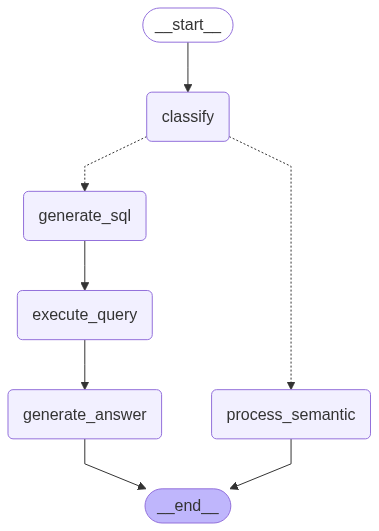

In [28]:
from IPython.display import Image, display
# Create and display the graph
react_graph = create_rag_pipeline()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Complete Graph Execution

In [29]:
graph = create_rag_pipeline()
state = graph.invoke({"question": "What is the average salary in Engineering?"})

# Print full trace
for m in state["messages"]:
    m.pretty_print()

# Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])

================================ Human Message =================================

Question: What is the average salary in Engineering?
================================== Ai Message ==================================

Classification: structured
================================ Human Message =================================

What is the average salary in Engineering?
================================== Ai Message ==================================

SELECT AVG(salary) FROM employees WHERE department = 'Engineering';
================================== Ai Message ==================================

Query Results:
[
  {
    "AVG(salary)": 77500.0
  }
]
================================== Ai Message ==================================

Answer:
The average salary in Engineering is $77,500.

💡 Final Answer:
 The average salary in Engineering is $77,500.


----------------------

In [32]:
graph = create_rag_pipeline()
state = graph.invoke({"question": "What is a short definition of machine learning Engineering?"})

# Print full trace
for m in state["messages"]:
    m.pretty_print()

# Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])

================================ Human Message =================================

Question: What is a short definition of machine learning Engineering?
================================== Ai Message ==================================

Classification: semantic
================================== Ai Message ==================================

Answer:
Machine Learning Engineering is a field of computer science that involves the development and application of algorithms and models that allow computers to learn from and make decisions or predictions based on data. It combines software engineering with data science to create systems and infrastructure capable of learning from data, improving performance, and delivering accurate results.

💡 Final Answer:
 Machine Learning Engineering is a field of computer science that involves the development and application of algorithms and models that allow computers to learn from and make decisions or predictions based on data. It combines software enginee

In [35]:
graph = create_rag_pipeline()
state = graph.invoke({"question": "What is the average salary in the Engineering department, by the way, can you give me the definition of engineering?"})

# Print full trace
for m in state["messages"]:
    m.pretty_print()

# Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])

================================ Human Message =================================

Question: What is the average salary in the Engineering department, by the way, can you give me the definition of engineering?
================================== Ai Message ==================================

Classification: hybrid
================================ Human Message =================================

What is the average salary in the Engineering department, by the way, can you give me the definition of engineering?
================================== Ai Message ==================================

SELECT AVG(salary) FROM employees WHERE department = 'Engineering';
================================== Ai Message ==================================

Query Results:
[
  {
    "AVG(salary)": 77500.0
  }
]
================================== Ai Message ==================================

Answer:
The average salary in the Engineering department is $77,500. 

As for the definition of engineering, it is a di

In [36]:
graph = create_rag_pipeline()
state = graph.invoke({"question": "What is the average salary in the Marketing department, and how many employees are in this department?"})

# Print full trace
for m in state["messages"]:
    m.pretty_print()

# Print final answer
print("\n💡 Final Answer:\n", state["final_answer"])

================================ Human Message =================================

Question: What is the average salary in the Marketing department, and how many employees are in this department?
================================== Ai Message ==================================

Classification: structured
================================ Human Message =================================

What is the average salary in the Marketing department, and how many employees are in this department?
================================== Ai Message ==================================

SELECT AVG(salary) AS average_salary, COUNT(*) AS number_of_employees 
FROM employees 
WHERE department = 'Marketing';
================================== Ai Message ==================================

Query Results:
[
  {
    "average_salary": 65000.0,
    "number_of_employees": 1
  }
]
================================== Ai Message ==================================

Answer:
The average salary in the Marketing department is $

--------------